# Comparison between real distributions and synthetic distributions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance
from scipy.stats import chisquare, chi2_contingency

import matplotlib.pyplot as plt
import math
from bokeh.io import push_notebook, show, output_notebook, export_png, export_svgs
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge
output_notebook()

Loading BokehJS ...

Choice of the synthetic database

In [2]:
"""
# Simulation of the departement Bouche du Rhone and Var
conn = sqlite3.connect("snds_8313.db")
dpt1="83"
dpt2="13"
"""
"""
# Simulation of the departement Cotes d'Armor and Iles et Vilaine
conn = sqlite3.connect("snds_2235.db")
dpt1="22"
dpt2="35"
"""
conn = sqlite3.connect("snds_2235.db")
dpt1="22"
dpt2="35"

## Analysis of the synthetic population structure

We start by loading the real population structure from raw data.

In [3]:
import os.path
outdir="../datarep"
pop_saq = pd.read_csv( os.path.join(outdir,"pop.csv") )
pop_tot = pop_saq['pop'].sum()

/home/tguyet/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


And new, we extract the synthetic population structure from the database

In [4]:
# On effectue une requête pour extraire les informations sur la population
df = pd.read_sql_query("SELECT BEN_SEX_COD, BEN_RES_DPT, BEN_NAI_ANN, count(*) FROM IR_BEN_R GROUP BY BEN_SEX_COD, BEN_RES_DPT, BEN_NAI_ANN;", conn)
df.rename(columns={'BEN_SEX_COD':'sex','BEN_RES_DPT':'dpt', 'count(*)':'count'}, inplace=True)
df['age']=2019-df.BEN_NAI_ANN
df=df[['sex','dpt','age','count']]

### Comparison of ages

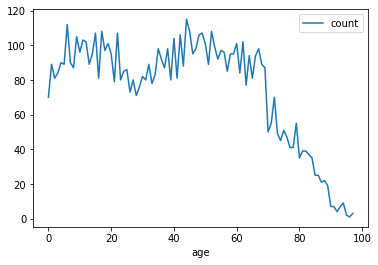

In [5]:
df_age=df.groupby(["age"]).agg({"count":"sum"}).reset_index()
df_age.plot(x='age',y="count")

In [6]:
# Ages are grouped in 5-years group to have the same structure as the real data
age_bins=list(np.arange(0,100,5))
age_bins.append(125)
df_age['bin']=pd.cut(df_age.age,bins=age_bins,include_lowest=True, labels=age_bins[:-1])
df_age_agg=df_age.groupby('bin').agg({"count":"sum"}).reset_index()
df_age_agg.head()

,bin,count
0,0,503
1,5,490
2,10,496
3,15,482
4,20,437


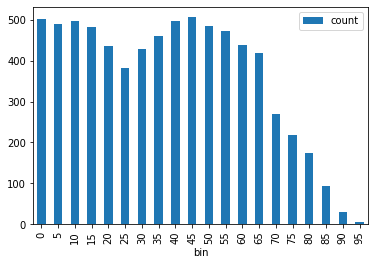

In [7]:
df_age_agg.plot.bar(x='bin',y="count")

In [8]:
#real population (selection of the two generated populations)
pop_seq_dpt=pop_saq[ (pop_saq['dpt']==dpt1) | (pop_saq['dpt']==dpt2)].groupby(['age']).agg({'pop':'sum'}).reset_index()
real_pop_size=sum(pop_seq_dpt['pop'])

In [9]:
#the number of patients of the real population is proportionnaly scaled to the level of the synthetic database
ratio = sum(df_age_agg['count'])/sum(pop_seq_dpt['pop'])
pop_seq_dpt['pop'] *= ratio

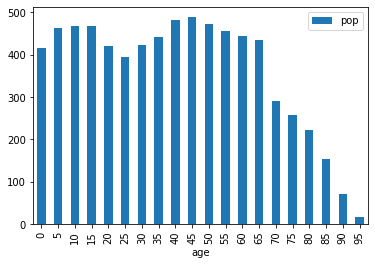

In [10]:
pop_seq_dpt.plot.bar(x="age",y="pop")

In [11]:
# We draw a graph to compare the two distributions
pops=pd.merge(pop_seq_dpt, df_age_agg, left_on="age", right_on="bin")[['age','pop','count']].rename(columns={'count':'pop_sim'})

p = figure(title=None, x_range=(-1,96), y_range=(0,700), plot_width=600, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('age', -0.5, range=p.x_range), top='pop', source=ColumnDataSource(pops), width=1,legend_label="Real")
p.vbar(x=dodge('age', +0.5, range=p.x_range), top='pop_sim', fill_color="orange", width=1, source=ColumnDataSource(pops),legend_label="Synth")
p.legend.location = "top_right"
#p.xaxis.axis_label = 'ATC codes'
p.yaxis.axis_label = 'Nb'
show(p)

In [12]:
# Compute of the total absolute difference between the two distributions
print( np.sum(np.abs(pops['pop_sim']-pops['pop']))/np.sum(pops['pop']) )
# Compute of the mean absolute difference between the two distributions
print( np.mean(np.abs(pops['pop_sim']-pops['pop'])/pops['pop']) )

0.07089113531905383
0.14271080019170973


### Kolmogorov-Smirnov test
The Kolmogorov-Smirnov test tests whether two one-dimensional distributions differ. 

$D_{n,m}=\max(F_r(x),F_s(x))$ where $F_r$ (resp. $F_s$) is the cumulative distribution function of the real population (resp. synthetic population), and $m$, $n$ are the population sizes (number of samples).

the null hypothesis is rejected at level $\alpha$ (ie it really differs) if the difference is above a critical value:
$$D_{n,m}>c(\alpha)\sqrt{\frac{n + m}{n\cdot m}}$$

where $c\left(\alpha\right)=\sqrt{-\ln\left(\tfrac{\alpha}{2}\right)\cdot \tfrac{1}{2}}$.

<br>

In the following, we use $n=m$ equals to the size of the sampled database. 


In [13]:
# Cumulative distribution functions
P_r = pops['pop'].to_numpy()/pops['pop'].sum()
CDF_r = np.cumsum(P_r)
P_s = pops['pop_sim'].to_numpy()/pops['pop_sim'].sum()
CDF_s = np.cumsum(P_s)

In [14]:
#Implementation of the Kolmogorov-Smirnov test
alpha=0.05 #95% critical value 
m=sum(df_age_agg['count'])
n=real_pop_size
statistic=np.max(np.abs(CDF_r-CDF_s))
critical_value= np.sqrt(-np.log(alpha/2)*0.5)*np.sqrt( (n+m)/(m*m) )
print(statistic>critical_value)
print(statistic)
print(critical_value)

False
0.033798076120968634
0.2400785049232967


We conclude that the distributions are not significantly different (p<0.05).

### KL Divergence / JS divergence

Kullback-Leibler (KL) Divergence is a measure based on entropy to compare two distributions $P$ and $P$. The Jensen-Shannon is the symmetric version of KL divergence.

$$D_\text{KL}(P \parallel Q) = \sum_{x\in\mathcal{X}} P(x) \log\left(\frac{P(x)}{Q(x)}\right)$$

and 
$$D_\text{JS}(P \parallel Q) = \frac{1}{2}D_\text{KL}(P \parallel Q) + \frac{1}{2}D_\text{KL}(Q \parallel P)$$

In [15]:
# calculate the kl divergence
def kl_divergence(p, q):
    return sum(p[i] * np.log(p[i]/q[i])/np.log(2) for i in range(len(p)))
 
# calculate the js divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

Then, we simply have to apply the function on our distributions



In [16]:
js_divergence(pops['pop'].to_numpy()/pops['pop'].sum(), pops['pop_sim'].to_numpy()/pops['pop_sim'].sum())

0.003185998903671821

### Wasserstein distance (Earth's mover distance)

In [17]:
wasserstein_distance(pops['pop'].to_numpy()/pops['pop'].sum(), pops['pop_sim'].to_numpy()/pops['pop_sim'].sum())

0.003242889047420164

### Now ... the same for genders


In [18]:
df_sex=df.groupby(["sex"]).agg({"count":"sum"}).reset_index()
df_sex

,sex,count
0,1,3499
1,2,3789


In [19]:
pop_sex_dpt=pop_saq[ (pop_saq['dpt']==dpt1) | (pop_saq['dpt']==dpt2)].groupby(['sex']).agg({'pop':'sum'}).reset_index()
pop_sex_dpt

,sex,pop
0,1,803202.200578
1,2,849321.477434


In [20]:
#same proportion for figures
pop_sex_dpt['pop'] = ratio*pop_sex_dpt['pop']
pops_sex=pd.merge(pop_sex_dpt,df_sex,on='sex').rename(columns={"count":"pop_sim"})

In [21]:
pops_sex['sex']=pops_sex['sex'].astype("str").str.replace("1","M").replace("2","F")
p = figure(title=None, x_range=pops_sex['sex'].to_numpy(), y_range=(0,5000), plot_width=400, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('sex', -0.2, range=p.x_range), top='pop', source=ColumnDataSource(pops_sex), width=0.4,legend_label="Real")
p.vbar(x=dodge('sex', +0.2, range=p.x_range), top='pop_sim', fill_color="orange", width=0.4, source=ColumnDataSource(pops_sex),legend_label="Synth")
p.legend.location = "bottom_right"
#p.xaxis.axis_label = 'ATC codes'
p.yaxis.axis_label = 'Nb'
show(p)

### Quantitiative Comparisons

We perform $\chi^2$ test, and then we compute some distances.

In [22]:
chisquare(pops_sex['pop_sim'].to_numpy(), pops_sex['pop'].to_numpy())

Power_divergenceResult(statistic=1.0299173880525148, pvalue=0.3101780716287681)

Here, the p-value is >0.05, then the null hypotheses (i.e. $H_0$: the two samples have the distribution) can not be rejected.

We simply compute the JS divergence in this case (not a continuous distribution)

In [23]:
js_divergence(pops_sex['pop'].to_numpy()/pops_sex['pop'].sum(), pops_sex['pop_sim'].to_numpy()/pops_sex['pop_sim'].sum())

2.5494157302622354e-05

In [24]:
wasserstein_distance(pops_sex['pop'].to_numpy()/pops_sex['pop'].sum(), pops_sex['pop_sim'].to_numpy()/pops_sex['pop_sim'].sum())

0.0059415235161789925

## Analysis of the drug distributions

In [25]:
# On effectue une requête pour extraire les informations sur les médicaments (nombres de prescriptions par ATC 3)
# -> là on a les chiffres généré pour 2 départements, sur 1 an
df = pd.read_sql_query("SELECT PHA_ATC_C03, sum(PHA_ACT_QSN) FROM er_pha_f JOIN ir_pha_r ON ir_pha_r.PHA_CIP_C13=er_pha_f.PHA_PRS_C13 GROUP BY PHA_ATC_C03;", conn)
df.rename(columns={'PHA_ATC_C03':'ATC2','sum(PHA_ACT_QSN)':'nb'}, inplace=True)
df

,ATC2,nb
0,A01,1941
1,A02,9503
2,A03,3832
3,A04,727
4,A05,161
...,...,...
72,S02,470
73,V01,45
74,V03,104
75,V04,39


In [26]:
# data for the French population, during a year
data = pd.read_csv("../data/OPEN_MEDIC_2019.zip", header=0, sep=';', encoding="latin_1")[['ATC2','BOITES']]
data = data.groupby("ATC2").agg({'BOITES':'sum'}).reset_index().rename(columns={'BOITES':"nb"})

In [27]:
data.head()

,ATC2,nb
0,A01,22941566
1,A02,100746397
2,A03,48505314
3,A04,8452671
4,A05,1954634


In [28]:
#we compute the population proportionality ratio
ratio = sum( df_age_agg['count'] )/pop_tot

In [29]:
df_cmp=pd.merge(data,df,how="left",on='ATC2',suffixes=('','_sim')).fillna(0)
df_cmp['nb'] *= ratio
df_cmp.head()

,ATC2,nb,nb_sim
0,A01,2519.580129,1941.0
1,A02,11064.572487,9503.0
2,A03,5327.143985,3832.0
3,A04,928.322935,727.0
4,A05,214.669608,161.0


In [30]:
p = figure(title=None, x_range=df_cmp['ATC2'].to_numpy(), plot_width=1200, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('ATC2', -0.2, range=p.x_range), top='nb_sim', fill_color="orange", width=0.4, source=ColumnDataSource(df_cmp),legend_label="Synth")
p.vbar(x=dodge('ATC2', +0.2, range=p.x_range), top='nb', source=ColumnDataSource(df_cmp), width=0.4,legend_label="Real")
p.legend.location = "top_right"
#p.xaxis.axis_label = 'ATC codes'
p.yaxis.axis_label = 'Nb'
show(p)

### Quantitiative Comparisons

We perform $\chi^2$ test, and then a compute some distances.

In [31]:
chisquare(df_cmp['nb_sim'].to_numpy(), df_cmp['nb'].to_numpy())

Power_divergenceResult(statistic=6512.677162690217, pvalue=0.0)

Here, the p-value is null, then the null hypotheses (i.e. $H_0$: the two samples have the distribution) is rejected.

We now simply compute the JS divergence in this case (not a continuous distribution)

In [32]:
js_divergence(df_cmp['nb'].to_numpy()/df_cmp['nb'].sum(), df_cmp['nb_sim'].to_numpy()/df_cmp['nb_sim'].sum())

<ipython-input-15-953c0830fea7>:3: RuntimeWarning: divide by zero encountered in log
  return sum(p[i] * np.log(p[i]/q[i])/np.log(2) for i in range(len(p)))
<ipython-input-15-953c0830fea7>:3: RuntimeWarning: invalid value encountered in double_scalars
  return sum(p[i] * np.log(p[i]/q[i])/np.log(2) for i in range(len(p)))


nan

In [33]:
wasserstein_distance(df_cmp['nb'].to_numpy()/df_cmp['nb'].sum(), df_cmp['nb_sim'].to_numpy()/df_cmp['nb_sim'].sum())

0.0009224829477298312

In [34]:
# Compute of the total absolute difference between the two distributions
print( np.sum(np.abs(df_cmp['nb_sim']-df_cmp['nb']))/np.sum(df_cmp['nb']) )
# Compute of the mean absolute difference between the two distributions
print( np.mean(np.abs(df_cmp['nb_sim']-df_cmp['nb'])/df_cmp['nb']) )

0.1264402365710224
0.20731764539312633


## Analysis of medical technical procedures

In [35]:
# Database query to extract procedures from the synthetic database
df = pd.read_sql_query("SELECT CAM_PRS_IDE, CAM_PRS_RGT, count(*) FROM er_cam_f JOIN ir_ccam_v63 ON er_cam_f.CAM_PRS_IDE=ir_ccam_v63.CAM_PRS_IDE_COD GROUP BY CAM_PRS_IDE, CAM_PRS_RGT;", conn)
df.rename(columns={'CAM_PRS_IDE':'ccam','CAM_PRS_RGT':'grp','count(*)':'nb'}, inplace=True)
df.head()

,ccam,grp,nb
0,ACQH001,ADI,1
1,ACQH002,ADI,2
2,ACQH003,ADI,22
3,ACQJ001,ADI,1
4,ACQJ002,ADI,43


In [36]:
procedures = pd.read_excel("../data/Actes_techniques_de_la_CCAM_en_2016.xls", sheet_name='Panorama des actes CCAM')
procedures.rename(columns={"Code Acte":'ccam',"Code Regroupement":"grp", "Quantité d'actes ":"nb"}, inplace=True)
procedures=procedures.groupby(['ccam',"grp"]).agg({"nb":"sum"}).reset_index()

In [37]:
#selection of procedures that are actually used in our simulation
#procedures=procedures[ (procedures['grp']=="ADC") | (procedures['grp']=="ACO") |(procedures['grp']=="ADA") |(procedures['grp']=="ADE") |(procedures['grp']=="ADI") |(procedures['grp']=="ADT") ]
procedures=procedures[ (procedures['grp']=="ADC") | (procedures['grp']=="ACO") |(procedures['grp']=="ADE") |(procedures['grp']=="ADI") |(procedures['grp']=="ADT") ]
procedures=procedures[ (procedures['ccam'].str[:2]!="HB") ]

In [38]:
procedures.head()

,ccam,grp,nb
1,AAFA001,ADC,103
3,AAFA002,ADC,446
5,AAFA003,ADC,9
7,AAFA005,ADC,9
9,AAFA006,ADC,2


In [39]:
procs_tot=procedures.groupby(['ccam']).agg({"nb":"sum"}).reset_index()

In [40]:
procs_tot.head()

,ccam,nb
0,AAFA001,103
1,AAFA002,446
2,AAFA003,9
3,AAFA005,9
4,AAFA006,2


In [41]:
procs_tot['nb'] *= ratio

In [42]:
procs_tot.head()

,ccam,nb
0,AAFA001,0.011312
1,AAFA002,0.048982
2,AAFA003,0.000988
3,AAFA005,0.000988
4,AAFA006,0.000220


### Comparison of the distribution of procedures per groups

In [43]:
procs_grp=procedures.groupby(['grp']).agg({"nb":"sum"}).reset_index()
procs_grp['nb'] *= ratio

In [44]:
df_grp=df.groupby("grp").agg({"nb":"sum"}).reset_index()

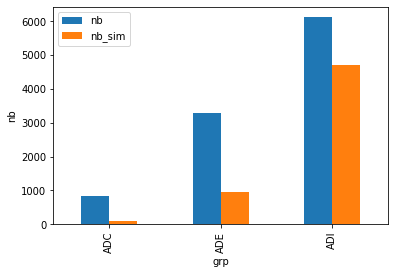

In [45]:
grps=pd.merge(procs_grp, df_grp,on="grp", suffixes=('','_sim'))

fig, axs = plt.subplots()
grps.set_index("grp").plot.bar(ax=axs)
axs.set_ylabel("nb")
fig.savefig("ccam_grp_"+str(dpt1)+str(dpt2)+".svg")

In [46]:
procs_ccam=procedures.groupby(['ccam']).agg({"nb":"sum"}).reset_index()
procs_ccam['nb'] *= ratio
#procs_ccam['nb'] = procs_ccam['nb'].astype(int)
df_ccam=df.groupby("ccam").agg({"nb":"sum"}).reset_index()
ccams=pd.merge(procs_ccam, df_ccam, on="ccam", suffixes=('','_sim'))

In [47]:
p = figure(title=None, x_range=ccams['ccam'].to_numpy(), y_range=(0,1200), plot_width=1200, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('ccam', -0.2, range=p.x_range), top='nb', source=ColumnDataSource(ccams), width=0.4,legend_label="Real")
p.vbar(x=dodge('ccam', +0.2, range=p.x_range), top='nb_sim', fill_color="orange", width=0.4, source=ColumnDataSource(ccams),legend_label="Synth")
p.legend.location = "top_left"
#p.xaxis.axis_label = 'CCAM procedures'
p.yaxis.axis_label = 'Nb'
show(p)

In [48]:
p = figure(title=None, x_range=ccams['ccam'][ (ccams['ccam']>="NFKA008") & (ccams['ccam']<="QEQK005") ].to_numpy(), plot_width=1200, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('ccam', -0.2, range=p.x_range), top='nb', source=ColumnDataSource(ccams), width=0.4,legend_label="Real")
p.vbar(x=dodge('ccam', +0.2, range=p.x_range), top='nb_sim', fill_color="orange", width=0.4, source=ColumnDataSource(ccams),legend_label="Synth")
p.legend.location = "top_left"
#p.xaxis.axis_label = 'CCAM procedures'
p.yaxis.axis_label = 'Nb'
show(p)

### Quantitiative Comparisons

We perform $\chi^2$ test, and then a compute some distances.

In [49]:
chisquare(ccams['nb_sim'][ (ccams['nb_sim']>5) & (ccams['nb']>5) & (ccams['ccam']>="NFKA008") & (ccams['ccam']<="NGQK002") ].to_numpy(), ccams['nb'][ (ccams['nb_sim']>5) & (ccams['nb']>5) & (ccams['ccam']>="NFKA008") & (ccams['ccam']<="NGQK002") ].to_numpy(), ddof=1)

Power_divergenceResult(statistic=31.848218437400966, pvalue=6.366896456000184e-06)

Here, the $p$-value is null, then the null hypotheses (i.e. $H_0$: the two samples have the distribution) is rejected.

We now simply compute the JS divergence in this case (not a continuous distribution)

In [50]:
js_divergence(ccams['nb'].to_numpy()/ccams['nb'].sum(), ccams['nb_sim'].to_numpy()/ccams['nb_sim'].sum())

0.04455242321596659

In [51]:
wasserstein_distance(ccams['nb'].to_numpy()/ccams['nb'].sum(), ccams['nb_sim'].to_numpy()/ccams['nb_sim'].sum())

0.0003764122598231488

In [52]:
# Compute of the total absolute difference between the two distributions
print( np.sum(np.abs(ccams['nb_sim']-ccams['nb']))/np.sum(ccams['nb']) )
# Compute of the mean absolute difference between the two distributions
print( np.mean(np.abs(ccams['nb_sim']-ccams['nb'])/ccams['nb']) )

0.42376656479603786
1.5748851864202984
